In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import config, os
from shapely.validation import make_valid
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Patch

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

Trash CRS: EPSG:4326
Seoul CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["GCS_ITRF_2000",DATUM["D_ITRF_2000",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127.5],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1000000],PARAMETER["false_northing",2000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

📌 서울 데이터 컬럼: ['nm', 'geometry']
📌 구 이름 목록:
['종로구' '중구' '용산구' '성동구' '광진구' '동대문구' '중랑구' '성북구' '강북구' '도봉구' '노원구' '은평구'
 '서대문구' '마포구' '양천구' '강천구' '구로구' '금천구' '영등포구' '동작구' '관악구' '서초구' '강남구' '송파구'
 '강동구']

📌 전체 구 개수: 25
📌 마포구 필터링 결과: 1개
📌 마포구 쓰레기통 필터링 결과: 254개

📌 마포구 bounds: [ 942906.60244304 1948483.45361469  952623.33665071 1954735.40765838]
📌 쓰레기통 bounds: [ 945127.23407269 1948935.81030175  952227.91445217 1954284.69681597]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35016\3598881561.py:87: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left')


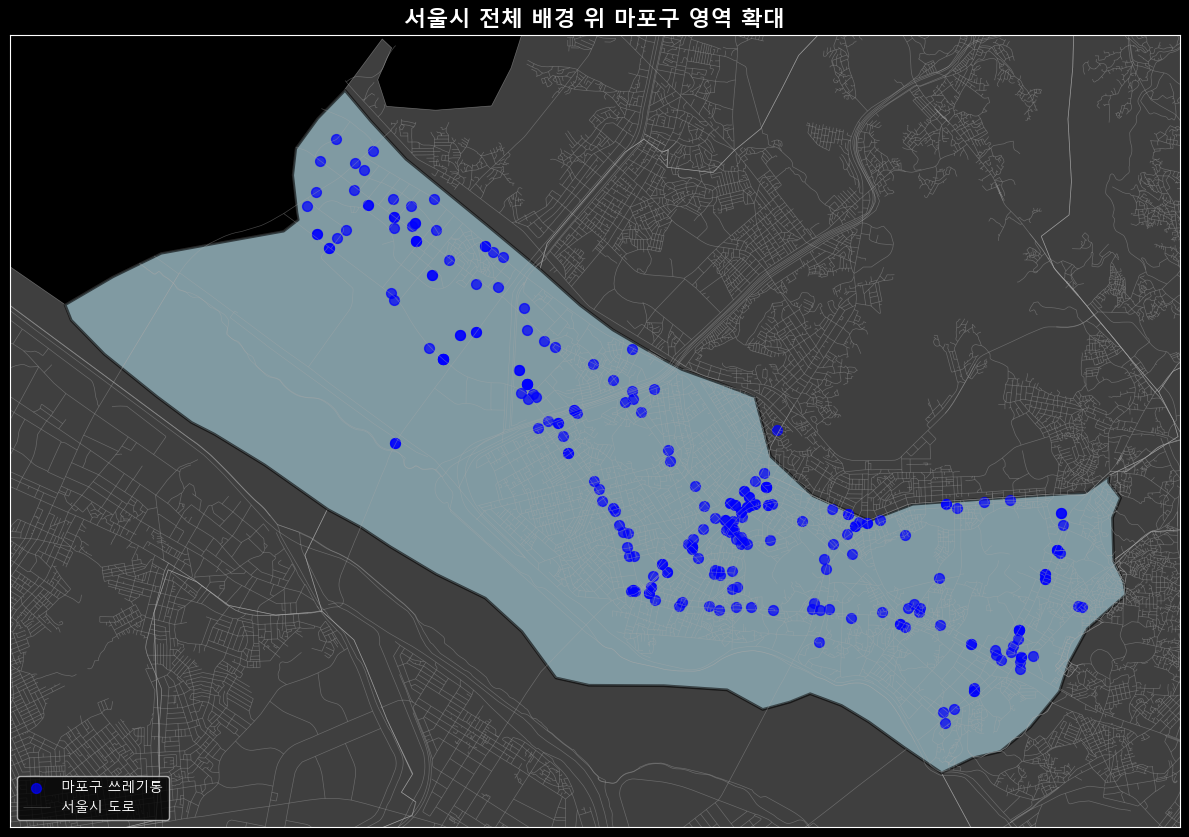

In [2]:
# 예: 쓰레기통 용량과 위치 데이터가 스케일이 다를 때
scaler = MinMaxScaler()

# 1️⃣ 데이터 경로
trash_path = os.path.join(config.DATA_DIR, '서울특별시 쓰레기통 202312/a.shp')
seoul_path = os.path.join(config.DATA_DIR, '서울 구경계 지오코딩/seoul_EPSG5179.shp')
road_path = os.path.join(config.DATA_DIR, '(도로명주소)도로구간_서울/TL_SPRD_MANAGE_11_202511.shp')

# 2️⃣ 데이터 불러오기
trash = gpd.read_file(trash_path)
seoul = gpd.read_file(seoul_path, engine='fiona', encoding='utf-8')  # utf-8 대신 cp949
road = gpd.read_file(road_path, encoding='cp949')

# geometry 유효성 검사
seoul['geometry'] = seoul['geometry'].apply(
    lambda geom: make_valid(geom) if geom and not geom.is_valid else geom
)

# 3️⃣ 좌표계 확인
print("Trash CRS:", trash.crs)
print("Seoul CRS:", seoul.crs)

# 4️⃣ 좌표계 통일
trash = trash.to_crs(seoul.crs)

# 5️⃣ 데이터 확인 (중요!)
print("\n📌 서울 데이터 컬럼:", seoul.columns.tolist())
print("📌 구 이름 목록:")
print(seoul['nm'].unique())
print(f"\n📌 전체 구 개수: {len(seoul)}")

# 마포구 선택
mapo = seoul[seoul['nm'] == '마포구']
print(f"📌 마포구 필터링 결과: {len(mapo)}개")

mapo_trash = trash[trash['field1']== '마포구']
print(f"📌 마포구 쓰레기통 필터링 결과: {len(mapo_trash)}개")

# ⚠️ 마포구가 비어있으면 전체 서울 표시
if mapo.empty:
    print("⚠️ 마포구를 찾을 수 없습니다! 전체 서울을 표시합니다.")
    mapo = seoul  # 임시로 전체 표시

# 6️⃣ 범위 확인
print(f"\n📌 마포구 bounds: {mapo.total_bounds}")
print(f"📌 쓰레기통 bounds: {mapo_trash.total_bounds}")

# 7️⃣ 시각화
fig, ax = plt.subplots(figsize=(12, 10))

# 1. 배경으로 전체 서울 구 경계를 연하게 표시 (전체를 그리는 단계)
# 'seoul' GeoDataFrame을 사용합니다.
seoul.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5, alpha=0.3, label='서울시 전체')

# 2. 마포구 경계만 진하게 강조
mapo.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=2, alpha=0.6, label='마포구 경계')

# 3. 마포구 쓰레기통 위치 표시
mapo_trash.plot(ax=ax, color='blue', markersize=50, alpha=0.7, label='마포구 쓰레기통')

# 4. 서울시 도로
road.plot(ax=ax, color='darkgray', linewidth=0.5, alpha=0.4, label='서울시 도로')

# 4. 축 범위를 마포구에 맞춤 (잘라내는 단계: 줌인 효과)
if not mapo.empty:
    # 마포구의 경계(bounds)를 가져와 축의 범위를 설정합니다.
    margin = 500  # 경계로부터 500m 여백
    x_min, y_min, x_max, y_max = mapo.total_bounds
    
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    
    # 불필요한 x, y 축 틱 제거
    ax.set_xticks([])
    ax.set_yticks([])

plt.title("서울시 전체 배경 위 마포구 영역 확대", fontsize=16, fontweight='bold')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [24]:
# 1️⃣ 데이터 경로
seoul_commerce_b_path = os.path.join(config.DATA_DIR, '상권 배후지 영역 좌표/서울시 상권분석서비스(영역-상권배후지).shp')

# 2️⃣ 데이터 불러오기
seoul_commerce_b = gpd.read_file(seoul_commerce_b_path, encoding='utf-8')  # utf-8 대신 cp949

# 3️⃣ 좌표계 확인
print("Seoul CRS:", seoul_commerce_b.crs)

# 5️⃣ 데이터 확인 (중요!)
print("\n📌 서울 상권 데이터 컬럼:", seoul_commerce_b.columns.tolist())
print(f"\n📌 전체 구: {seoul_commerce_b['SIGNGU_CD_'].unique()}")

seoul_commerce_b_mapo = seoul_commerce_b[seoul_commerce_b['SIGNGU_CD_'] == '마포구']

Seoul CRS: EPSG:5181

📌 서울 상권 데이터 컬럼: ['ALLEY_TRDA', 'ALLEY_TR_1', 'XCNTS_VALU', 'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_', 'RELM_AR', 'geometry']

📌 전체 구: ['종로구' '중구' '성북구' '강북구' '광진구' '동대문구' '도봉구' '용산구' '성동구' '중랑구' '노원구' '은평구'
 '서대문구' '마포구' '양천구' '강서구' '서초구' '강남구' '구로구' '금천구' '영등포구' '동작구' '관악구' '송파구'
 '강동구']


In [25]:
# 1️⃣ 데이터 경로
seoul_commerce_path = os.path.join(config.DATA_DIR, '상권 영역 좌표/서울시 상권분석서비스(영역-상권).shp')

# 2️⃣ 데이터 불러오기
seoul_commerce = gpd.read_file(seoul_commerce_path, encoding='utf-8')  # utf-8 대신 cp949

# 3️⃣ 좌표계 확인
print("Seoul CRS:", seoul_commerce.crs)

# 5️⃣ 데이터 확인 (중요!)
print("\n📌 서울 상권 데이터 컬럼:", seoul_commerce.columns.tolist())
print(f"\n📌 전체 구: {seoul_commerce['SIGNGU_CD_'].unique()}")

seoul_commerce_mapo = seoul_commerce[seoul_commerce['SIGNGU_CD_'] == '마포구']

Seoul CRS: EPSG:5181

📌 서울 상권 데이터 컬럼: ['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU', 'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_', 'RELM_AR', 'geometry']

📌 전체 구: ['종로구' '중구' '용산구' '성동구' '광진구' '동대문구' '중랑구' '성북구' '강북구' '도봉구' '노원구' '은평구'
 '서대문구' '마포구' '양천구' '강서구' '구로구' '금천구' '영등포구' '동작구' '관악구' '서초구' '강남구' '송파구'
 '강동구']


In [26]:
dong_path = os.path.join(config.DATA_DIR, '행정동 영역 좌표/서울시 상권분석서비스(영역-행정동).shp')

dong = gpd.read_file(dong_path, encoding='utf-8')

print("Dong CRS:", dong.crs)

print("\n📌 서울 상권 데이터 컬럼:", dong.columns.tolist())

dong_mapo = dong[dong['ADSTRD_NM'].isin(list(seoul_commerce_mapo.ADSTRD_CD_.unique()))]
print("\n📌 마포구 행정동(from 영역 상권):", sorted(seoul_commerce_mapo.ADSTRD_CD_.unique().tolist()))
print("\n📌 마포구 행정동(from 영역 행정동):", sorted(dong_mapo.ADSTRD_NM.tolist()))

Dong CRS: EPSG:5181

📌 서울 상권 데이터 컬럼: ['ADSTRD_CD', 'ADSTRD_NM', 'XCNTS_VALU', 'YDNTS_VALU', 'RELM_AR', 'geometry']

📌 마포구 행정동(from 영역 상권): ['공덕동', '대흥동', '도화동', '망원1동', '망원2동', '상암동', '서강동', '서교동', '성산1동', '성산2동', '신수동', '아현동', '연남동', '염리동', '용강동', '합정동']

📌 마포구 행정동(from 영역 행정동): ['공덕동', '대흥동', '도화동', '망원1동', '망원2동', '상암동', '서강동', '서교동', '성산1동', '성산2동', '신수동', '아현동', '연남동', '염리동', '용강동', '합정동']


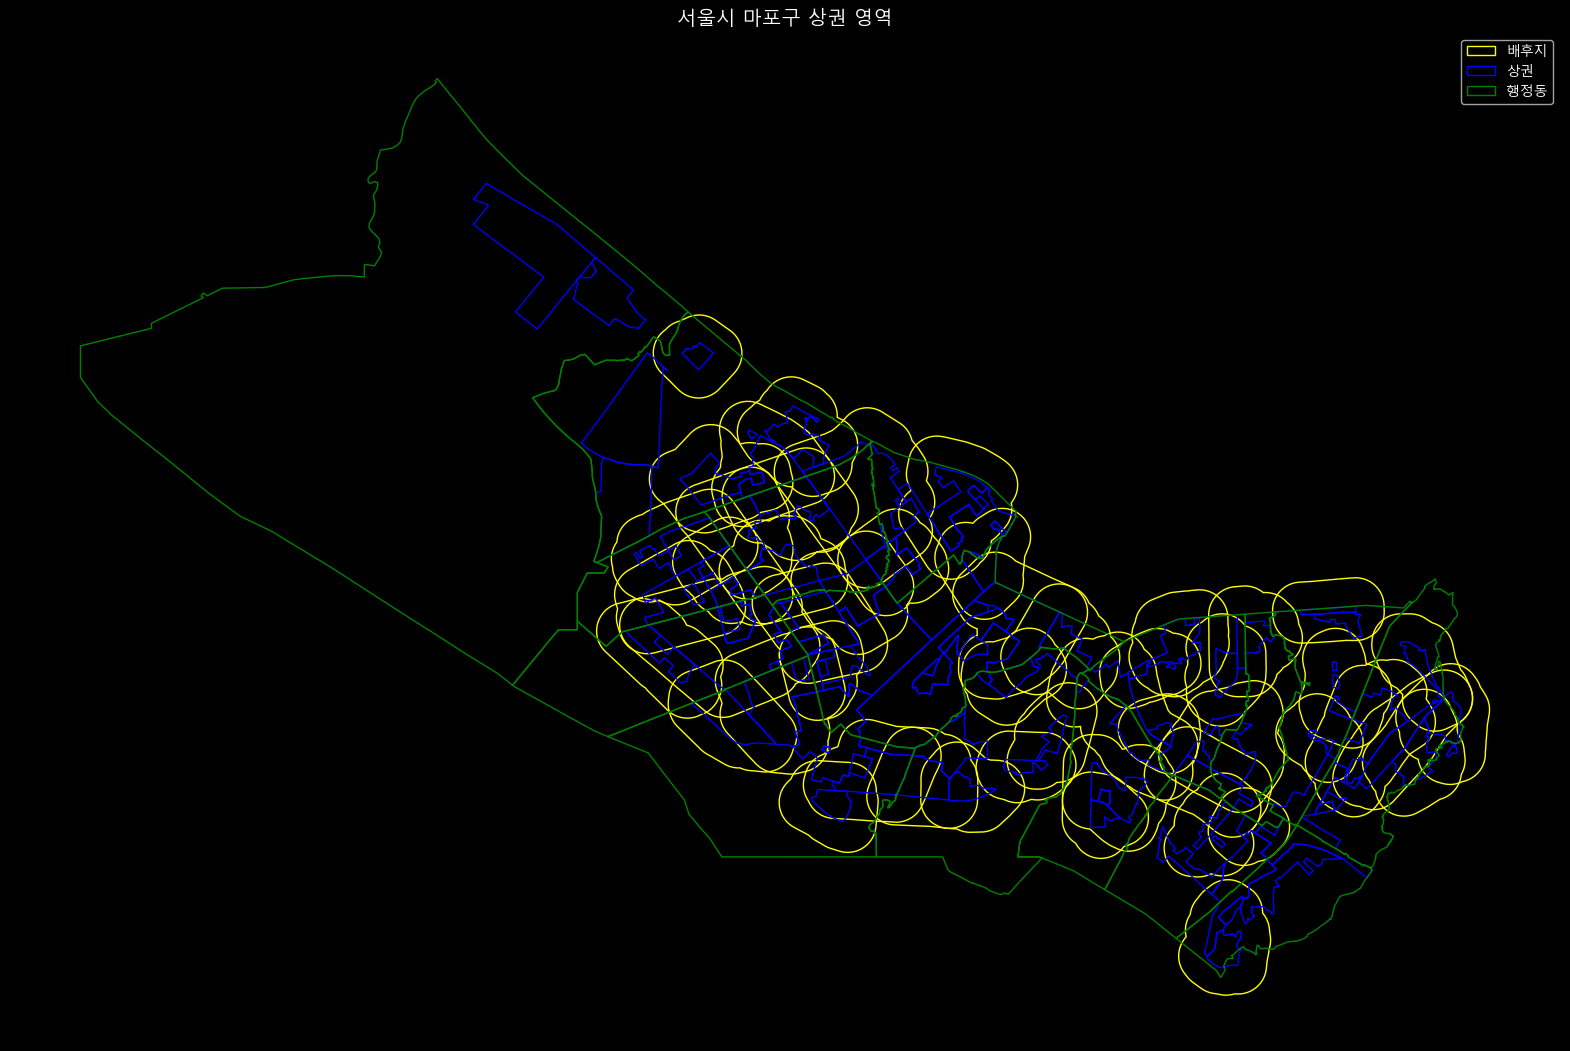

In [35]:
fig, ax = plt.subplots(figsize=(20, 16))
seoul_commerce_b_mapo.plot(ax=ax, color='none', edgecolor='yellow')
seoul_commerce_mapo.plot(ax=ax, color='none', edgecolor='blue')
dong_mapo.plot(ax=ax, color='none', edgecolor='green')

legend_elements = [
    Patch(facecolor='none', edgecolor='yellow', label='배후지'),
    Patch(facecolor='none', edgecolor='blue', label='상권'),
    Patch(facecolor='none', edgecolor='green', label='행정동')
]
ax.legend(handles=legend_elements)
ax.set_title("서울시 마포구 상권 영역", fontsize=14)
ax.axis('off')
plt.show()

In [6]:
import pandas as pd

print(f'원본 상권 수: {len(seoul_commerce_mapo.TRDAR_CD)}')

def print_out_valid(df_path):
  path = os.path.join(config.DATA_DIR, '서울 상권분석서비스(상권 기준)', df_path)
  df = pd.read_csv(path, encoding='cp949')
  year_list = df['기준_년분기_코드'].tolist()
  df = df[df['기준_년분기_코드']==max(year_list)] # 가장 최신 것
  df['상권_코드'] = df['상권_코드'].apply(lambda x : str(x))
  val_df = df[df['상권_코드'].isin(seoul_commerce_mapo.TRDAR_CD)]
  print(f'valid 상권 수: {len(val_df)}')
  return val_df

paths = ['서울시 상권분석서비스(길단위인구-상권).csv', '서울시 상권분석서비스(상주인구-상권).csv', '서울시 상권분석서비스(소득소비-상권).csv',
         '서울시 상권분석서비스(아파트-상권).csv', '서울시 상권분석서비스(점포-상권).csv', '서울시 상권분석서비스(직장인구-상권).csv',
         '서울시 상권분석서비스(집객시설-상권).csv', '서울시 상권분석서비스(추정매출-상권).csv']

dataframes = []

for p in paths:
  dataframes.append(print_out_valid(p))

원본 상권 수: 77
valid 상권 수: 77
valid 상권 수: 75
valid 상권 수: 75
valid 상권 수: 70
valid 상권 수: 3760
valid 상권 수: 76
valid 상권 수: 73
valid 상권 수: 1014


In [68]:
# 대부분 5번 컬럼 인덱스
# 점포: 6번(서비스 업종 명), 7번(점포 수) (4번 data)
# 추정매출: 6번 (7번 data)

def change_col_name(df):
    new_pop_commerce = df.iloc[:, [3, 5]].rename(
        columns={'상권_코드':'TRDAR_CD'}
    )

    merged_df = pd.merge(seoul_commerce_mapo, new_pop_commerce, on='TRDAR_CD', how='inner')
    return merged_df

merged_dataframes = []

for idx, d in enumerate(dataframes[:4]):
    try:
        merged_dataframes.append(change_col_name(d))
    except Exception as e:
        print(f'{idx}:{e}')

for idx, d in enumerate(dataframes[5:7]):
    try:
        merged_dataframes.append(change_col_name(d))
    except Exception as e:
        print(f'{idx}:{e}')

new_df_jumpo = dataframes[4].iloc[:, [3, 6, 7]].rename(
        columns={'상권_코드':'TRDAR_CD'}
    )
merged_df_jumpo = pd.merge(seoul_commerce_mapo, new_df_jumpo, on='TRDAR_CD', how='inner')

new_df_pay = dataframes[7].iloc[:, [3, 6]].rename(
        columns={'상권_코드':'TRDAR_CD'}
    )
merged_df_pay = pd.merge(seoul_commerce_mapo, new_df_pay, on='TRDAR_CD', how='inner')


In [11]:
new_df_expenditure = dataframes[2].iloc[:, [3, 7]].rename(
        columns={'상권_코드':'TRDAR_CD'}
    )
merged_df_expenditure = pd.merge(seoul_commerce_mapo, new_df_expenditure, on='TRDAR_CD', how='inner')
merged_dataframes=[]
merged_dataframes.append(merged_df_expenditure)

In [12]:
merged_dataframes[0].columns

Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '지출_총금액'],
      dtype='object')

In [ ]:
df_dict = {}

def make_col_dict(df):
  print(df.columns)
  target_col = input('원하는 컬럼?: ')
  df_dict[target_col] = df

for d in merged_dataframes:
  make_col_dict(d)

Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '총_유동인구_수'],
      dtype='object')
Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '총_상주인구_수'],
      dtype='object')
Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '월_평균_소득_금액'],
      dtype='object')
Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '아파트_단지_수'],
      dtype='object')
Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'A

In [13]:
df_dict = {}

def make_col_dict(df):
  print(df.columns)
  target_col = input('원하는 컬럼?: ')
  df_dict[target_col] = df

for d in merged_dataframes:
  make_col_dict(d)

Index(['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU',
       'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_',
       'RELM_AR', 'geometry', '지출_총금액'],
      dtype='object')


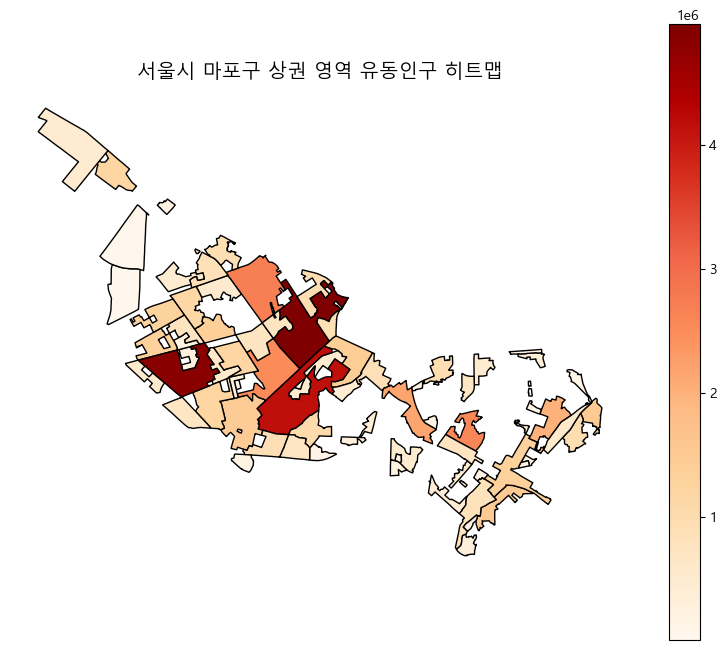

In [69]:
# 시각화
if len(merged_dataframes[0]) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    target_column = merged_dataframes[0].columns[-1]
    
    # POP 컬럼 기준으로 색 지정, cmap은 원하는 색상맵 선택 가능
    merged_dataframes[0].plot(column=target_column, ax=ax, cmap='OrRd', edgecolor='black', legend=True)
    
    plt.title("서울시 마포구 상권 영역 유동인구 히트맵", fontsize=14)
    plt.axis('off')  # 좌표 축 제거
    plt.show()
else:
    print("마포구 데이터를 찾을 수 없습니다.")

In [14]:
# 경로 지정
seoul_geojson_path = os.path.join(config.DATA_DIR, 'HangJeongDong_ver20250401.geojson')

# 데이터 불러오기
seoul_hang = gpd.read_file(seoul_geojson_path)

# 좌표계 통일
trash = trash.to_crs(seoul_hang.crs)

# 마포구만 선택 (컬럼 이름 확인 후 수정)
print(seoul_hang.columns)
# 마포구 데이터 필터링 (adm_nm에 '마포구'가 포함된 모든 행)
mapo_hang = seoul_hang[seoul_hang['sggnm'] == '마포구']

print(f"마포구 데이터 개수: {len(mapo_hang)}")
print(f"마포구 동 목록:\n{mapo_hang['adm_nm'].unique()}")

Index(['adm_nm', 'adm_cd2', 'sgg', 'sido', 'sidonm', 'sggnm', 'adm_cd',
       'geometry'],
      dtype='object')
마포구 데이터 개수: 16
마포구 동 목록:
['서울특별시 마포구 용강동' '서울특별시 마포구 대흥동' '서울특별시 마포구 염리동' '서울특별시 마포구 신수동'
 '서울특별시 마포구 서교동' '서울특별시 마포구 합정동' '서울특별시 마포구 망원1동' '서울특별시 마포구 망원2동'
 '서울특별시 마포구 연남동' '서울특별시 마포구 성산1동' '서울특별시 마포구 성산2동' '서울특별시 마포구 상암동'
 '서울특별시 마포구 도화동' '서울특별시 마포구 서강동' '서울특별시 마포구 공덕동' '서울특별시 마포구 아현동']


In [17]:
import folium
import branca.colormap as cm

def make_folium(merged_df, trash, target_col):
    # 1. 좌표계 변환 (Folium은 EPSG:4326 필요)
    if merged_df.crs != 'EPSG:4326':
        merged_df_wgs = merged_df.to_crs('EPSG:4326')
    else:
        merged_df_wgs = merged_df.copy()

    if trash.crs != 'EPSG:4326':
        trash_wgs = trash.to_crs('EPSG:4326')
    else:
        trash_wgs = trash.copy()

    if mapo_hang.crs != 'EPSG:4326':
        mapo_hang_wgs = mapo_hang.to_crs('EPSG:4326')
    else:
        mapo_hang_wgs = mapo_hang.copy()

    # 1. 결측값 제거
    merged_df_wgs = merged_df_wgs[merged_df_wgs[target_col].notna()].copy()

    # 2. 마포구 중심 좌표
    center = [merged_df_wgs.geometry.centroid.y.mean(), 
            merged_df_wgs.geometry.centroid.x.mean()]

    # 3. Folium 지도 생성 - 배경 지도 스타일 선택
    # 옵션 1: 밝은 회색 배경 (추천!)
    m = folium.Map(
        location=center, 
        zoom_start=13, 
        tiles='CartoDB positron',  # 흐린 배경
        attr='CartoDB'
    )

    # 옵션 2: 어두운 배경
    # m = folium.Map(location=center, zoom_start=13, tiles='CartoDB dark_matter')

    # 옵션 3: 배경 없음 (흰색)
    # m = folium.Map(location=center, zoom_start=13, tiles=None)
    # folium.TileLayer('CartoDB positron', attr='CartoDB', opacity=0.3).add_to(m)

    # 4. POP 기반 색상 맵 생성 (OrRd 컬러맵)
    pop_min = merged_df_wgs[target_col].min()
    pop_max = merged_df_wgs[target_col].max()

    colormap = cm.LinearColormap(
        colors=['#FFF5F0', '#FEE0D2', '#FCBBA1', '#FC9272', '#FB6A4A', '#EF3B2C', '#CB181D', '#99000D'],
        vmin=pop_min,
        vmax=pop_max,
        caption=target_col
    )

    # 5. 상권 영역 히트맵 (POP 기반 색칠)
    for idx, row in merged_df_wgs.iterrows():
        pop_value = row[target_col]
        color = colormap(pop_value)
        
        # 툴팁 정보 구성
        tooltip_text = f"""
        <b>상권명:</b> {row['TRDAR_CD_N']}<br>
        <b>{target_col}:</b> {pop_value:,.0f}명<br>
        <b>구분:</b> {row['TRDAR_SE_1']}<br>
        <b>시군구:</b> {row['SIGNGU_CD_']}
        """
        
        folium.GeoJson(
            row['geometry'].__geo_interface__,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'fillOpacity': 0.7,
                'color': 'black',
                'weight': 0.5,
                'opacity': 0.8
            },
            tooltip=folium.Tooltip(tooltip_text)
        ).add_to(m)

    # 6. 마포구 행정동 경계 (어두운 회색 선으로 조화)
    folium.GeoJson(
        mapo_hang_wgs,
        name='마포구 행정동',
        style_function=lambda x: {
            'fillColor': 'none',
            'color': '#555555',  # 어두운 회색
            'weight': 2.5,
            'opacity': 0.8,
            'fillOpacity': 0,
            'dashArray': '5, 5'  # 점선 스타일 (선택사항)
        },
        tooltip=folium.GeoJsonTooltip(fields=['adm_nm'], aliases=['행정동:'])
    ).add_to(m)

    # 7. 쓰레기통 위치 (주황색 계열로 히트맵과 조화)
    for idx, row in trash_wgs.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color='#8B0000',  # 어두운 빨강 테두리
            fill=True,
            fillColor='#FF4500',  # 주황빨강
            fillOpacity=0.8,
            weight=2,
            popup=f"쓰레기통 {idx}"
        ).add_to(m)

    # 8. 컬러바 범례 추가
    colormap.add_to(m)

    # 9. 레이어 컨트롤
    folium.LayerControl().add_to(m)

    print(f"✓ 지도 생성 완료!")
    print(f"  - 상권 개수: {len(merged_df_wgs)}")
    print(f"  - 쓰레기통 개수: {len(trash_wgs)}")
    print(f"  - POP 범위: {pop_min:,.0f} ~ {pop_max:,.0f}")
    return m

In [18]:
for col, df in df_dict.items():
  save_path = '마포구_쓰레기통_'+col+'_시각화.html'
  m = make_folium(df, mapo_trash, col)
  m.save(save_path)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35208\3123610971.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [merged_df_wgs.geometry.centroid.y.mean(),
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35208\3123610971.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_df_wgs.geometry.centroid.x.mean()]


✓ 지도 생성 완료!
  - 상권 개수: 71
  - 쓰레기통 개수: 254
  - POP 범위: 1,543,871 ~ 6,703,960,241
